# Polygon data download
With the Alpaca notebooks I tried to convert tick quote data to quotes and then merge them with bars. I have decided to not use quote data anymore. It is simply too expensive, cumbersome or simply impossible. I would have to download ALL tick data in order to get quotebars. Instead, I will just trade using 1-minute OHLC. This can be downloaded in a reasonable timeframe from Polygon, which also includes delisted stocks. When backtesting, I will assume a spread of 1 tick or a few cents. This is okay, because I simply will not trade systems with an average profit less than 0.3% for liquid stocks or less than 0.1% for liquid futures/CFDs. I also will avoid illiquid stocks. I will not do HFT. My holding period should be at least 10 minutes. If I do want to venture in sub 1-minute, I will just use QuantConnect instead.

My data pipeline will look like this:
1. Download descriptive data to <code>../../../data/polygon/processed/descriptive.csv</code>. This is a single file containing all stocks. The difference between descriptive and fundamental data is that this never changes. These contain e.g. the start/end date of listing, the sector, the country etc. (The start/end date is the only thing that changes.)
2. Download all raw 1-minute unadjusted data for all stocks for all dates (including delisted tickers) and store them in the <code>../../../data/polygon/raw/m1/\<stock\>.csv</code>. Raw price data contains <code>["unix", "open", "high", "low", "close", "vwap", "trades", "volume", "otc"]</code>. The <code>unix</code> column is the Unix timestamp. The <code>trades</code> column is the amount of trades in the minute and <code>otc</code> is a flag whether the asset is traded OTC. I will not trade OTCs yet. Higher resolutions are not downloaded, but aggregated later. Raw data is never deleted or modified.
3. Get adjustment factors and store to <code>../../../data/polygon/raw/adjustments/\<stock\>.csv</code>.
4. Download fundamental data to <code>../../../data/polygon/raw/fundamentals/\<stock\>.csv</code>. This contains P/E ratios etc.


Step 1 to 4 is repeated if I have to update data. Then new data is simply appended to the end of the csv files. I will not update frequently.

After downloading, the raw data has to be processed to the <code>../../../data/polygon/processed/</code> folder. For now, I will not process the fundamental/descriptive data. Processed data is always adjusted. When data is downloaded for the first time or updated, the *entire* data set needs be processed (for the updated tickers). This is because if new adjustments come in due to dividend or split data, the entire history needs to be readjusted. Processed data will contain the columns <code>["open", "high", "low", "close", "close_original", "volume", "vwap", "tradeable"]</code>. All prices are adjusted, except <code>close_original</code>. The reason we need the original close price is for price filters. Processed data will not contain OTC stocks for now. 

The steps when processing data:.
1. Convert the timestamps to (naive) ET time.
2. For illiquid stocks or extended hours not every minute a trade takes place. Also, I want my processed data to have no gaps, which makes pairs trading much easier. Every stock that is traded on a day should have the same amount of minute bars. To do this we need to reindex to the opening hours (4:00 to 20:00 ET, where regular hours are from 9:30 to 16:00) and forward fill empty values. However, some days have early closes and there are holidays. So we also need to get a list of dates the stock market is open. These will be stored in <code>../../../data/other/market_hours.csv</code>. If data is forward filled, the backtester should not trade these 'stale' prices. Either there have been no trades in the minute or the stock is halted. That is what the <code>tradeable</code> flag is for. It can happen that a stock is halted for multiple days (example: TOP). In this case, it will be treated just as empty prices which are forward filled.
3. Adjust the data using dividend and split data. Round to 4 digits after the comma.
4. Aggregate 1-minute bars to higher timeframes. Daily data contains only regular trading hours.

*Note: a data point at 15:59 with OHLC means that the open was at 15:59:00 and close at 16:00:00. So daily data does not contain the 16:00:00 minute bar. My polygon key is in <code>../../../data/polygon/secret.txt</code>, this file has to be created manually, just like the folders.*

*Note: This takes way more effort and time than expected*

In [2]:
from polygon.rest import RESTClient
from datetime import datetime, date, time, timedelta
from pytz import timezone
import pytz
import pandas as pd
import numpy as np
import plotly.graph_objects as go
import mplfinance as mpf

The free tier has a rate limit of 5/minute. Just listing the tickers already goes above the limit. So I will start with the cheapest (29/month) subscription. When I have everything setup, I will upgrade to the highest tier. But the current goal is to download data from all stocks from 2021-6-1 to 2023-8-18. If I am succesful with that, I will try to get it from the last 5 years which is the maximum for the "starter" subscription.

In [3]:
DATA_PATH = "../../../data/polygon/"

START_DATE = datetime(2021, 1, 1).date()
END_DATE = datetime(2023, 8, 18).date()

with open(DATA_PATH + "secret.txt") as f:
    KEY = next(f).strip()

client = RESTClient(api_key=KEY, verbose=True)

**Step 1**

1. Get all tickers and store descriptive data. We are only interested in common stocks (CS) and ADR commons (ADRC) in the US only that are not OTC. It must also include the delisted stocks. So we need to get 4 different set of tickers: CS+active, CS+inactive, ADRC+active, ADRC+inactive. Setting the <code>asset_class</code> to "stocks" only pulls non-OTC tickers. The <code>list_tickers</code> returns an iterator. Every iteration is 1 request with the specified <code>limit</code>.


In [3]:
print(pd.DataFrame(client.get_ticker_types(asset_class="stocks", locale="us")))

   asset_class     code                            description locale
0       stocks       CS                           Common Stock     us
1       stocks      PFD                        Preferred Stock     us
2       stocks  WARRANT                                Warrant     us
3       stocks    RIGHT                                 Rights     us
4       stocks     BOND                         Corporate Bond     us
5       stocks      ETF                   Exchange Traded Fund     us
6       stocks      ETN                   Exchange Traded Note     us
7       stocks      ETV                Exchange Traded Vehicle     us
8       stocks       SP                     Structured Product     us
9       stocks     ADRC     American Depository Receipt Common     us
10      stocks     ADRP  American Depository Receipt Preferred     us
11      stocks     ADRW   American Depository Receipt Warrants     us
12      stocks     ADRR     American Depository Receipt Rights     us
13      stocks     F

In [4]:
ticker_list_iterator_active = client.list_tickers(type="CS", date=END_DATE.isoformat(), active=True, market='stocks', limit=1000)
ticker_list_iterator_delisted = client.list_tickers(type="CS", date=END_DATE.isoformat(), active=False, market='stocks', limit=1000)
ticker_list_iterator_active_adr = client.list_tickers(type="ADRC", date=END_DATE.isoformat(), active=True, market='stocks', limit=1000)
ticker_list_iterator_delisted_adr = client.list_tickers(type="ADRC", date=END_DATE.isoformat(), active=False, market='stocks', limit=1000)
tickers_active = pd.DataFrame(ticker_list_iterator_active)
tickers_delisted = pd.DataFrame(ticker_list_iterator_delisted)
tickers_active_adr = pd.DataFrame(ticker_list_iterator_active_adr)
tickers_delisted_adr = pd.DataFrame(ticker_list_iterator_delisted_adr)

In [5]:
tickers_active.head(3)

,active,cik,composite_figi,currency_name,currency_symbol,base_currency_symbol,base_currency_name,delisted_utc,last_updated_utc,locale,market,name,primary_exchange,share_class_figi,ticker,type,source_feed
0,True,0001090872,BBG000C2V3D6,usd,None,None,None,None,2023-08-25T00:00:00Z,us,stocks,Agilent Technologies Inc.,XNYS,BBG001SCTQY4,A,CS,None
1,True,0001675149,BBG00B3T3HD3,usd,None,None,None,None,2023-08-25T00:00:00Z,us,stocks,Alcoa Corporation,XNYS,BBG00B3T3HF1,AA,CS,None
2,True,0001829432,None,usd,None,None,None,None,2023-08-25T00:00:00Z,us,stocks,Ares Acquisition Corporation,XNYS,None,AAC,CS,None


In [6]:
tickers_delisted.head(3)

,active,cik,composite_figi,currency_name,currency_symbol,base_currency_symbol,base_currency_name,delisted_utc,last_updated_utc,locale,market,name,primary_exchange,share_class_figi,ticker,type,source_feed
0,False,0000004281,None,usd,None,None,None,2016-10-07T00:00:00Z,2016-10-07T00:00:00Z,us,stocks,ALCOA INC,XNYS,None,AA,CS,None
1,False,0000004281,None,usd,None,None,None,2016-11-01T00:00:00Z,2016-11-01T00:00:00Z,us,stocks,"Alcoa, Inc.",XNYS,None,AA,CS,None
2,False,0001011006,BBG000KB2D74,usd,None,None,None,2019-10-07T00:00:00Z,2019-10-07T00:00:00Z,us,stocks,Altaba Inc. Common Stock,XNAS,BBG001S8V781,AABA,CS,None


In [7]:
tickers_active_adr.head(3)

,active,cik,composite_figi,currency_name,currency_symbol,base_currency_symbol,base_currency_name,delisted_utc,last_updated_utc,locale,market,name,primary_exchange,share_class_figi,ticker,type,source_feed
0,True,0001420529,BBG000V2S3P6,usd,None,None,None,None,2023-08-25T00:00:00Z,us,stocks,ATA Creativity Global American Depositary Shares,XNAS,BBG001T125S9,AACG,ADRC,None
1,True,0001492074,BBG00XRJJLG2,usd,None,None,None,None,2023-08-25T00:00:00Z,us,stocks,Abcam plc American Depositary Shares,XNAS,BBG00XRJJM98,ABCM,ADRC,None
2,True,0001565025,BBG000BN5VZ4,usd,None,None,None,None,2023-08-25T00:00:00Z,us,stocks,AMBEV S.A.,XNYS,BBG005KLVT74,ABEV,ADRC,None


In [8]:
tickers_delisted_adr.head(3)

,active,cik,composite_figi,currency_name,currency_symbol,base_currency_symbol,base_currency_name,delisted_utc,last_updated_utc,locale,market,name,primary_exchange,share_class_figi,ticker,type,source_feed
0,False,0001611787,BBG00K6FMBQ8,usd,None,None,None,2018-02-12T00:00:00Z,2018-02-12T00:00:00Z,us,stocks,Advanced Accelerator Applications S.A. America...,XNAS,BBG007K5CVB6,AAAP,ADRC,None
1,False,0001091587,BBG000DK5Q25,usd,None,None,None,2023-05-23T00:00:00Z,2023-05-23T00:00:00Z,us,stocks,ABB Ltd.,XNYS,BBG001SDDMX9,ABB,ADRC,None
2,False,0001617582,None,usd,None,None,None,2018-06-13T00:00:00Z,2018-06-13T00:00:00Z,us,stocks,Ablynx NV American Depositary Shares,XNAS,None,ABLX,ADRC,None


In [9]:
tickers = pd.concat([tickers_active, tickers_delisted, tickers_active_adr, tickers_delisted_adr]).reset_index()

Some basic checks to check for weird things:

In [10]:
# Check na values
tickers.isna().sum()

index                       0
active                      0
cik                       649
composite_figi           6175
currency_name               0
currency_symbol         13871
base_currency_symbol    13871
base_currency_name      13871
delisted_utc             5905
last_updated_utc            0
locale                      0
market                      0
name                        0
primary_exchange            0
share_class_figi         6175
ticker                      0
type                        0
source_feed             13871
dtype: int64

In [11]:
# Check unique values 
print(tickers['currency_name'].unique()) # Should be USD only
print(tickers['locale'].unique()) # Should be US only

['usd']
['us']


In [12]:
# Clean up and rearrange columns
tickers_active = tickers_active[['ticker', 'name', 'active', 'delisted_utc', 'last_updated_utc', 'cik', 'composite_figi', 'type']]
tickers_delisted = tickers_delisted[['ticker', 'name', 'active', 'delisted_utc', 'last_updated_utc', 'cik', 'composite_figi', 'type']]
tickers_active_adr = tickers_active_adr[['ticker', 'name', 'active', 'delisted_utc', 'last_updated_utc', 'cik', 'composite_figi', 'type']]
tickers_delisted_adr = tickers_delisted_adr[['ticker', 'name', 'active', 'delisted_utc', 'last_updated_utc', 'cik', 'composite_figi', 'type']]
tickers = tickers[['ticker', 'name', 'active', 'delisted_utc', 'last_updated_utc', 'cik', 'composite_figi', 'type']]

In [13]:
# Check if all tickers are unique
ticker_frequency = tickers.pivot_table(columns=['ticker'], aggfunc='size')
ticker_frequency[ticker_frequency > 1]

ticker
AA      3
AAC     4
AAN     4
AAU     2
AAV     2
       ..
ZME     2
ZOM     2
ZSAN    3
ZTR     2
ZYME    2
Length: 1978, dtype: int64

In [14]:
# Apparently they are not unique. There are more than 1800 duplications. Maybe it is because tickers get recycled after delisting?
ticker_frequency_active = tickers_active.pivot_table(columns=['ticker'], aggfunc='size')
ticker_frequency_active[ticker_frequency_active > 1]

Series([], dtype: int64)

In [15]:
# There are indeed no duplicates in the active stocks. The tickers are recycled:
tickers[tickers['ticker'] == "AAN"]


,ticker,name,active,delisted_utc,last_updated_utc,cik,composite_figi,type
10,AAN,"The Aaron's Company, Inc.",True,None,2023-08-25T00:00:00Z,0001821393,BBG00WCNDCZ6,CS
5492,AAN,AARON'S INC CL B,False,2010-12-14T00:00:00Z,2010-12-14T00:00:00Z,0000706688,None,CS
5493,AAN,"Aaron's, Inc.",False,2020-10-19T00:00:00Z,2020-10-19T00:00:00Z,0000706688,BBG00JZD1964,CS
5494,AAN,"Aaron''s Holdings Company, Inc.",False,2020-12-01T00:00:00Z,2020-12-01T00:00:00Z,0001821393,BBG00XYJSN34,CS


In [16]:
# We need to keep this in mind if we download historical data. Because we cannot just loop through all tickers and then store them in a csv. Because then the first ones will be overwritten.

# Maybe the cik is unique?
ticker_frequency = tickers.pivot_table(columns=['cik'], aggfunc='size')
ticker_frequency[ticker_frequency > 1]

cik
0000002186    3
0000002491    2
0000003197    2
0000003327    3
0000003453    2
             ..
0001951067    2
0001951222    2
0001955520    2
0001965040    2
0001968915    2
Length: 2416, dtype: int64

In [17]:
# There are also cik duplicates.
tickers[tickers['cik'] == "0000002186"]


,ticker,name,active,delisted_utc,last_updated_utc,cik,composite_figi,type
707,BKTI,BK Technologies Corporation,True,None,2023-08-25T00:00:00Z,0000002186,BBG00NKSM4N7,CS
6363,BKTI,BK Technologies Corporation,False,2023-04-24T00:00:00Z,2023-04-24T00:00:00Z,0000002186,BBG00NKSM4N7,CS
11432,RWC,RELM Wireless Corporation,False,2018-06-05T00:00:00Z,2018-06-05T00:00:00Z,0000002186,None,CS


What we can do to handle delisted tickers (e.g. multiple AAC) when downloading is:
- For the active tickers, just save the data in AAC.csv, as there are no duplicate tickers.
- For the inactive tickers, we will add the delisted year and month to the end of the ticker: AAC200901.csv. This is also what Norgate Data does. We will later see if there are edge cases where there are duplicates which are both delisted in the same month.
- We need to keep in mind that it is possible for a ticker to go to OTC and then back (see HTZ on TradingView). We will treat these cases as two different stocks, such that we do not trade OTC.

In [18]:
tickers.sort_values(by=['ticker'], inplace=True)
# We are not interested in stocks that were delisted before the start date
tickers['delisted_utc'] = pd.to_datetime(tickers['delisted_utc'])
tickers['last_updated_utc'] = pd.to_datetime(tickers['last_updated_utc'])
tickers = tickers[(tickers['delisted_utc'].dt.date > START_DATE) | tickers['delisted_utc'].isnull()]
tickers.reset_index(inplace=True, drop=True)
tickers.to_csv(DATA_PATH + 'processed/descriptive.csv')
tickers

,ticker,name,active,delisted_utc,last_updated_utc,cik,composite_figi,type
0,A,Agilent Technologies Inc.,True,NaT,2023-08-25 00:00:00+00:00,0001090872,BBG000C2V3D6,CS
1,AA,Alcoa Corporation,True,NaT,2023-08-25 00:00:00+00:00,0001675149,BBG00B3T3HD3,CS
2,AAC,Ares Acquisition Corporation,True,NaT,2023-08-25 00:00:00+00:00,0001829432,None,CS
3,AACG,ATA Creativity Global American Depositary Shares,True,NaT,2023-08-25 00:00:00+00:00,0001420529,BBG000V2S3P6,ADRC
4,AACI,Armada Acquisition Corp. I Common Stock,True,NaT,2023-08-25 00:00:00+00:00,0001844817,BBG011XR7306,CS
...,...,...,...,...,...,...,...,...
8178,ZY,Zymergen Inc. Common Stock,False,2022-10-20 00:00:00+00:00,2022-10-20 00:00:00+00:00,0001645842,BBG0077HPN74,CS
8179,ZYME,Zymeworks Inc.,False,2022-10-13 00:00:00+00:00,2022-10-13 00:00:00+00:00,0001403752,BBG00GD15LJ5,CS
8180,ZYME,Zymeworks Inc.,True,NaT,2023-08-25 00:00:00+00:00,0001937653,BBG019XSYC89,CS
8181,ZYNE,"Zynerba Pharmaceuticals, Inc",True,NaT,2023-08-25 00:00:00+00:00,0001621443,BBG007BBS8B7,CS


We now have the end dates. But to download the data we also need the start date. Let's try to get the start date of META. To get them we could use the <code>Ticker Details v3</code> endpoint. But this gets the *list date*. This is not necessarily the same as the start date of a ticker. E.g. FB changed their ticker to META, but what does ticker details give? We want 2022.

(If a ticker changes, just like normal, we treat them as 2 different stocks. In the end, we should thus get a META.csv and a FB.csv. We could merge them, however there is no way to get historical ticker changes for delisted stocks. Since ticker changes are rare, this is not a big problem.)



In [19]:
meta_details = client.get_ticker_details(ticker = "META")
meta_details.list_date

'2012-05-18'

In [20]:
result = client.get_ticker_events(ticker="META")
result

TickerChangeResults(name='Meta Platforms, Inc. Class A Common Stock', composite_figi='BBG000MM2P62', cik='0001326801', events=[{'ticker_change': {'ticker': 'META'}, 'type': 'ticker_change', 'date': '2022-06-09'}, {'ticker_change': {'ticker': 'FB'}, 'type': 'ticker_change', 'date': '2012-05-18'}])

The start date of META is 2022-06-09. But the list date is the one from FB from 2012. We cannot use <code>get_ticker_events</code> to get the events of old tickers, because it only lists the events of the entity currently represented by the ticker. So to reiterate, our current goal is to get the 2022-06-09 without <code>get_ticker_events</code>.

What happens if we download data from a ticker that has multiple changes? If we use META we expect only data from 2022-06-09 to now. If we use FB we expect data from 2012 to 2022-06-08.

In [119]:
meta_iterator = client.get_aggs(ticker = "META", multiplier = 1, timespan = "day", from_ = "2010-01-01", to = "2023-08-18", limit=50000)
meta_d1 = pd.DataFrame(meta_iterator)
meta_d1["timestamp"] = pd.to_datetime(meta_d1["timestamp"], unit="ms").dt.date
meta_d1.rename(columns={"timestamp": "date"}, inplace=True)
meta_d1


,open,high,low,close,volume,vwap,date,transactions,otc
0,15.0800,15.19,15.042,15.12,334935.0,15.1107,2021-06-30,2101,None
1,15.1300,15.13,14.840,14.89,241629.0,15.0126,2021-07-01,2092,None
2,15.0200,15.10,14.930,15.00,388152.0,15.0224,2021-07-02,4733,None
3,15.0800,15.09,14.870,15.01,685094.0,15.1119,2021-07-06,11269,None
4,15.0601,15.15,14.840,14.89,362538.0,14.9830,2021-07-07,5538,None
...,...,...,...,...,...,...,...,...,...
443,300.9800,306.21,298.250,306.19,15641921.0,303.0529,2023-08-14,206053,None
444,306.1400,307.23,300.030,301.95,11623613.0,302.9223,2023-08-15,171652,None
445,300.1950,301.08,294.280,294.29,18547741.0,297.3013,2023-08-16,261408,None
446,293.0500,296.05,284.950,285.09,23950089.0,289.9367,2023-08-17,311835,None


This is absolutely not what we expected. We expected data from either 2022-06-09 (from when the ticker was renamed) or the start of FB (in 2012). This means that there was a ticker named META before FB renamed.

In [ ]:
tickers[tickers['ticker'] == "META"]

In [23]:
tickers[tickers['ticker'] == "FB"]

,ticker,name,active,delisted_utc,last_updated_utc,cik,composite_figi,type


What? Why is there no META ticker before 2022-06-09? Why is there no FB ticker?

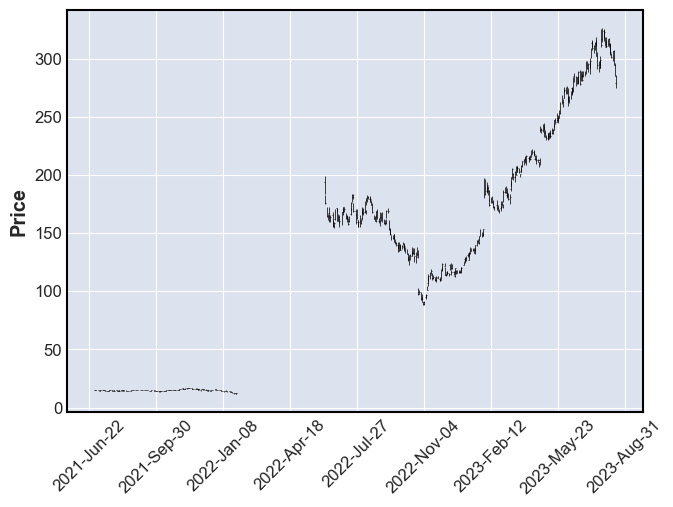

In [120]:
# fig = go.Figure(data=go.Ohlc(x=meta_d1['date'],
#                     open=meta_d1['open'],
#                     high=meta_d1['high'],
#                     low=meta_d1['low'],
#                     close=meta_d1['close']))
# fig.show()

meta_d1.set_index("date", inplace=True)
meta_d1.index = pd.to_datetime(meta_d1.index)
mpf.plot(meta_d1, type='ohlc', show_nontrading=True)

Why?

In [25]:
fb_iterator = client.get_aggs(ticker = "FB", multiplier = 1, timespan = "day", from_ = "2010-01-01", to = "2023-08-18", limit=50000)
fb_d1 = pd.DataFrame(fb_iterator)
fb_d1["timestamp"] = pd.to_datetime(fb_d1["timestamp"], unit="ms").dt.date
fb_d1.rename(columns={"timestamp": "date"}, inplace=True)
fb_d1

,open,high,low,close,volume,vwap,date,transactions,otc
0,175.990,178.6700,175.7900,177.46,17921935.0,177.4215,2018-08-27,143926,None
1,178.100,178.2399,175.8300,176.26,15910675.0,176.9467,2018-08-28,118276,None
2,176.295,176.7900,174.7500,175.90,18667201.0,175.6846,2018-08-29,127665,None
3,175.900,179.7901,175.7000,177.64,24216532.0,178.2862,2018-08-30,172773,None
4,177.150,177.6200,174.9815,175.73,18065159.0,175.7343,2018-08-31,135914,None
...,...,...,...,...,...,...,...,...,...
948,188.450,200.9350,187.7300,198.86,31951582.0,195.8094,2022-06-02,336899,None
949,195.980,196.6100,189.7800,190.78,19464993.0,192.0885,2022-06-03,239486,None
950,193.990,196.9200,188.4000,194.25,30574242.0,193.2857,2022-06-06,307707,None
951,191.930,196.5300,191.4900,195.65,18628687.0,194.4583,2022-06-07,204288,None


Why does there exist data for FB if the ticker list does not include it? I thought the <code>Tickers</code> endpoint did not rename but only added new tickers. Apparently that is not the case:

In [26]:
ticker_list_iterator_fb = client.list_tickers(ticker="FB", type="CS", date="2023-08-18", active=True, market='stocks', limit=1000)
df = pd.DataFrame(ticker_list_iterator_fb)
df

""


In [27]:
ticker_list_iterator_fb = client.list_tickers(ticker="FB", type="CS", date="2022-06-01", active=False, market='stocks', limit=1000)
df = pd.DataFrame(ticker_list_iterator_fb)
df

""


In [28]:
ticker_list_iterator_fb = client.list_tickers(ticker="FB", type="CS", date="2022-06-01", active=True, market='stocks', limit=1000)
df = pd.DataFrame(ticker_list_iterator_fb)
df

,active,cik,composite_figi,currency_name,currency_symbol,base_currency_symbol,base_currency_name,delisted_utc,last_updated_utc,locale,market,name,primary_exchange,share_class_figi,ticker,type,source_feed
0,True,0001326801,BBG000MM2P62,usd,None,None,None,None,2022-06-08T00:00:00Z,us,stocks,"Meta Platforms, Inc. Class A Common Stock",XNAS,BBG001SQCQC5,FB,CS,None


In [29]:
ticker_list_iterator_fb = client.list_tickers(ticker="FB", type="CS", date="2022-06-10", active=True, market='stocks', limit=1000)
df = pd.DataFrame(ticker_list_iterator_fb)
df

""


Apparently when a stock renames, the <code>Tickers</code> gets updated by removing the old ticker and adding the new one. It also does not treat it as a delisting (there is no <code>delisted_utc</code>).

And the old META stock (not facebook) is gone. There is no way to get the start and end date of that one.

In [30]:
ticker_list_iterator_meta = client.list_tickers(ticker="META", type="CS", date="2022-01-01", active=True, market='stocks', limit=1000)
df = pd.DataFrame(ticker_list_iterator_meta)
df

""


In [31]:
ticker_list_iterator_meta = client.list_tickers(ticker="META", type="CS", date="2022-01-01", active=False, market='stocks', limit=1000)
df = pd.DataFrame(ticker_list_iterator_meta)
df

""


In [32]:
client.get_ticker_details(ticker="META", date="2022-01-01")

TickerDetails(active=True, address=None, branding=None, cik=None, composite_figi='BBG011J1MN62', currency_name='usd', currency_symbol=None, base_currency_name=None, base_currency_symbol=None, delisted_utc=None, description=None, ticker_root='META', ticker_suffix=None, homepage_url=None, list_date='2021-06-30', locale='us', market='stocks', market_cap=None, name='Roundhill Ball Metaverse ETF', phone_number=None, primary_exchange='ARCX', share_class_figi='BBG011J1MP12', share_class_shares_outstanding=60080000, sic_code=None, sic_description=None, ticker='META', total_employees=None, type='ETF', weighted_shares_outstanding=None)

Apparently I overlooked the possibility that the old META stock was actually an ETF. This is really an edge case that we need to handle and I am glad I caught it early on. Maybe we can get the delisting date.

In [33]:
ticker_list_iterator_meta = client.list_tickers(ticker="META", date="2022-01-01", active=True, market='stocks', limit=1000)
df = pd.DataFrame(ticker_list_iterator_meta)
df

,active,cik,composite_figi,currency_name,currency_symbol,base_currency_symbol,base_currency_name,delisted_utc,last_updated_utc,locale,market,name,primary_exchange,share_class_figi,ticker,type,source_feed
0,True,None,BBG011J1MN62,usd,None,None,None,None,2022-01-02T00:00:00Z,us,stocks,Roundhill Ball Metaverse ETF,ARCX,BBG011J1MP12,META,ETF,None


Expectation: if we now change the date to 2022-04-01 (where the META ETF was delisted but before the FB stock rename), we should get a delisted_utc for the META ETF.

In [34]:
ticker_list_iterator_meta = client.list_tickers(ticker="META", date="2022-04-01", active=False, market='stocks', limit=1000)
df = pd.DataFrame(ticker_list_iterator_meta)
df

""


We do not get anything, just like with FB. In fact, the META ETF was renamed to METV. But there is no way to get the METV directly (I simply found this out by searching for the ETF on TradingView). Because if you search up <code>Ticker Events</code> you get the FB -> META change, and not the META -> METV change. If we search for METV we do get the META -> METV change, but we would never have gotten METV in the first case. In the end when we have acquired all data (including METV), maybe we can merge the tickers that have been renamed. In this case we already have all tickers so we can loop over them.

This is quite problematic. The only way to get the end date of the META ETF (or FB) is to loop through all trading days in <code>Tickers</code> and see when the ticker dissappears. (Although we do not care about ETFs this could as well have been a stock). The only way to get the start date of the META or FB is also to loop, but then to track when the ticker appears. Or use the <code>Ticker Events</code> however this only works for current tickers and not delisted ones. So information actually gets lost in the <code>Tickers</code> endpoint.

Who thought that just getting all available tickers would be such a headache? We haven't even begun downloading data.

To summarize:
- Getting data is truly point-in-time, there is no META data for 2022-04-01 (after META ETF, before FB rename), but there is FB for before the META rename. If the same ticker had different stocks, they are merged which we do not want. So we **must** specify a precise start and end date and make sure that they are not named the same stock in our database.
- The <code>Tickers</code> endpoint does **not** include FB or the old META if we use the current date, even though we would expect a delisting. So the <code>Tickers</code> is also point in time and **deletes** some data, such as FB. My assumption that renamings simply gets 'delisted' and then added was incorrect.

So we will loop and create an own version of a list of all tickers with start and end dates. This will include FB, which would not be the case if we only used the current date in <code>Tickers</code>. It would also include the old META ETF if it was a stock. This would be impossible to get without looping.

First a small experiment: What is the earliest data that Polygon has? I simply used trial-and-error. The earliest date is 2003-09-10. That is quite a lot. 

In [35]:
ticker_list_iterator = client.list_tickers(date="2003-09-10", active=True, market='stocks', limit=1000)
df = pd.DataFrame(ticker_list_iterator)
len(df)

8204

In order to loop through the trading dates, we still need to get the trading dates. Also there are holidays and early closes. We can infer the holidays by just looking at daily SPY data. But this does not include information about early closes. The goal is to create a csv with dates and the start times of pre-market and regular hours and end times of post-market.

The early closes are listed on [QuantConnect](https://www.quantconnect.com/docs/v2/writing-algorithms/securities/asset-classes/us-equity/market-hours).

So we will first get a list of all trading dates using SPY data. The regular hours always start at 9:30 ET. The start of premarket is 4:00 ET. To test if it is always 4:00 ET we will compare it to the time of the first trade of SPY rounded down to the first hour. There are no early or late opens. To get the close we will use 16:00 ET or 13:00 ET if it is an early close. The post-market ends 4 hours after close. To test if this is true we will also compare. 

In [17]:
# Download daily and minute SPY data.
trading_hours = pd.DataFrame(client.get_aggs(ticker = "SPY", multiplier = 1, timespan = "day", from_ = "2019-01-01", to = "2023-08-18", limit=50000))
trading_hours["timestamp"] = pd.to_datetime(trading_hours["timestamp"], unit="ms").dt.date
trading_hours.rename(columns = {"timestamp": "date"}, inplace=True)
trading_hours = trading_hours[["date"]]

In [77]:
trading_hours["premarket_open"] = time(4)
trading_hours["regular_open"] = time(9, 30)

# I will not bother scraping. On all days here the early close is 13:00 ET.
early_closes = ['1999-11-26','2000-07-03','2000-11-24','2001-07-03','2001-11-23',
'2001-12-24','2002-07-05','2002-11-29','2002-12-24','2003-07-03','2003-11-28',
'2003-12-24','2003-12-26','2004-11-26','2005-11-25','2006-07-03','2006-11-24',
'2007-07-03','2007-11-23','2007-12-24','2008-07-03','2008-11-28','2008-12-24',
'2009-11-27','2009-12-24','2010-11-26','2011-11-25','2012-07-03','2012-11-23',
'2012-12-24','2013-07-03','2013-11-29','2013-12-24','2014-07-03','2014-11-28',
'2014-12-24','2015-11-27','2015-12-24','2016-11-25','2017-07-03','2017-11-24',
'2017-12-24','2018-07-03','2018-11-23','2018-12-24','2019-07-03','2019-11-29',
'2019-12-24','2020-11-27','2020-12-24','2021-11-26','2022-11-25','2023-07-03',
'2023-11-24','2024-07-03',]

early_closes = [datetime.strptime(date, "%Y-%m-%d").date() for date in early_closes]

In [19]:
trading_hours["regular_close"] = trading_hours["date"].isin(early_closes)
trading_hours["regular_close"] = trading_hours["regular_close"].apply(lambda boolean: time(13) if boolean else time(16))
trading_hours["postmarket_close"] = pd.to_datetime(trading_hours['date'].astype(str) + " " + trading_hours["regular_close"].astype(str)) + timedelta(hours=4)
trading_hours["postmarket_close"] = trading_hours["postmarket_close"].dt.time
trading_hours.set_index("date", inplace=True)
trading_hours.to_csv(DATA_PATH + "../other/market_hours.csv")
trading_hours[1130:1135]

,premarket_open,regular_open,regular_close,postmarket_close
date,,,,
2023-06-29,04:00:00,09:30:00,16:00:00,20:00:00
2023-06-30,04:00:00,09:30:00,16:00:00,20:00:00
2023-07-03,04:00:00,09:30:00,13:00:00,17:00:00
2023-07-05,04:00:00,09:30:00,16:00:00,20:00:00
2023-07-06,04:00:00,09:30:00,16:00:00,20:00:00


According to [Schwab](https://www.schwab.com/public/schwab/nn/qq/about_extended_hours_trading.html) there are no extended hours on trading days with early closes. I could not find confirmation for this so I will test this claim.

(The reason why we need to be precise about this is for the backtester and for aggregating into daily bars.)

In [8]:
def datetime_to_unix(year=None, month=None, date=None, hour=0, minute=0, dt=None):
    """
    Converts a ET datetime to the corresponding Unix msec stamp.
    The input can either be year/month/date or a datetime object.
        Input must be either
            year : int
            month : int
            date : int
            hour : int (optional)
            minute : int (optional)
        Or
            dt : datetime (keyword-only)
    """
    if all(isinstance(value, int) for value in (year, month, date, hour, minute)):
        time_ET = timezone("US/Eastern").localize(datetime(year, month, date, hour, minute))
    elif isinstance(dt, datetime):
        time_ET = timezone("US/Eastern").localize(dt)
    else:
        raise Exception("No year/month/date or datetime object specified.")
    
    return int(time_ET.timestamp()*1000)

def download_m1_raw_data(ticker, from_, to, path):
    """
    Downloads 1-minute data from Polygon, converts to ET-naive time and store. Includes extended hours.
        ticker : str
        from_ : tuple(year : int, month : int, date : int) or datetime
        to : tuple(year : int, month : int, date : int) or datetime
        path : str
    """
    # Check if int or datetime given for from_, then get start_unix
    if isinstance(from_, datetime):
        start_unix = datetime_to_unix(dt = from_)
    elif all(isinstance(value, int) for value in from_):
        start_unix = datetime_to_unix(*from_, hour=4) # (* unpacks the tuple)
    else:
        raise Exception("No year/month/date or datetime object specified.")
    
    # Check if int or datetime given for to, then get end_unix
    if isinstance(to, datetime):
        end_unix = datetime_to_unix(dt = to)
    elif all(isinstance(value, int) for value in to):
        end_unix = datetime_to_unix(*to, hour =20) # (* unpacks the tuple)
    else:
        raise Exception("No year/month/date or datetime object specified.")

    m1 = pd.DataFrame(client.list_aggs(ticker = ticker, multiplier = 1, timespan = "minute", from_ = start_unix, to = end_unix, limit=10000))
    m1["timestamp"] = pd.to_datetime(m1["timestamp"], unit="ms") # Convert timestamp to UTC
    m1.rename(columns = {"timestamp": "datetime"}, inplace=True)
    m1["datetime"] = m1["datetime"].dt.tz_localize(pytz.UTC) # Make UTC aware (in order to convert)
    m1["datetime"] = m1["datetime"].dt.tz_convert("US/Eastern") # Convert UTC to ET
    m1["datetime"] = m1["datetime"].dt.tz_localize(None) # Make timezone naive 
    m1.set_index("datetime", inplace=True)
    m1.to_csv(path)

download_m1_raw_data("SPY", from_ = (2019, 1, 2), to = (2023, 8, 18), 
path = DATA_PATH + "/raw/m1/SPY.csv")


Let's first test if the trading days match between daily and minute bars.

In [90]:
SPY_m1 = pd.read_csv(
        DATA_PATH + "/raw/m1/SPY.csv",
        parse_dates=True,
        index_col="datetime",
        usecols=["datetime"]
    )
market_hours = pd.read_csv(
        DATA_PATH + "../other/market_hours.csv",
        index_col="date",
        parse_dates=True,
    )

market_open_days = set(market_hours.index.date)
# Test for duplicated days in daily data, should be False
print(all(market_hours.duplicated()))

market_open_days_m1 = set(SPY_m1.index.date)

# We might have that there are more data in the market_hours than a specific stock. So we only have to test for containment.
print(market_open_days_m1.issubset(market_open_days))

# In this case however, the daily and minute match exactly:
print(market_open_days.issubset(market_open_days_m1))

False
True
True


Now we will test if the first minute of trading always matches 4:00 ET. As there are not always trades, we will only look at the hour.

In [91]:
SPY_m1["date"] = SPY_m1.index.date
SPY_m1["hour"] = SPY_m1.index.hour
SPY_m1

,date,hour
datetime,,
2019-01-02 04:00:00,2019-01-02,4
2019-01-02 04:01:00,2019-01-02,4
2019-01-02 04:02:00,2019-01-02,4
2019-01-02 04:03:00,2019-01-02,4
2019-01-02 04:04:00,2019-01-02,4
...,...,...
2023-08-18 19:53:00,2023-08-18,19
2023-08-18 19:56:00,2023-08-18,19
2023-08-18 19:57:00,2023-08-18,19


In [92]:
SPY_open = SPY_m1[~SPY_m1["date"].duplicated()] # By removing duplicates we get the first 1-minute bar of each day.
SPY_open[SPY_open["hour"] != 4]

,date,hour
datetime,,


Hence the pre-market always starts at 4:00 ET. Even for early closes. Now let's check post-market hours for early closes. On 2023-7-3 the market closed at 13:00 ET. We would then expect the post-market to continue for 4 hours until 17:00 ET instead ot 20:00 ET.

In [93]:
SPY_m1[SPY_m1['date'] == date(2023, 7, 3)]

,date,hour
datetime,,
2023-07-03 04:00:00,2023-07-03,4
2023-07-03 04:01:00,2023-07-03,4
2023-07-03 04:02:00,2023-07-03,4
2023-07-03 04:03:00,2023-07-03,4
2023-07-03 04:04:00,2023-07-03,4
...,...,...
2023-07-03 16:43:00,2023-07-03,16
2023-07-03 16:45:00,2023-07-03,16
2023-07-03 16:52:00,2023-07-03,16


Indeed this is the case. The 16:59 minute means that the market closes at 17:00. Let's see if this is the case for all early closes.

In [96]:
SPY_close = SPY_m1[~SPY_m1["date"].duplicated(keep="last")] # By removing duplicates except the last we get the last 1-minute bar of a day.
SPY_close

,date,hour
datetime,,
2019-01-02 19:59:00,2019-01-02,19
2019-01-03 19:59:00,2019-01-03,19
2019-01-04 19:59:00,2019-01-04,19
2019-01-07 19:59:00,2019-01-07,19
2019-01-08 19:59:00,2019-01-08,19
...,...,...
2023-08-14 19:59:00,2023-08-14,19
2023-08-15 19:59:00,2023-08-15,19
2023-08-16 19:59:00,2023-08-16,19


In [97]:
SPY_close[SPY_close["hour"] != 19]

,date,hour
datetime,,
2019-07-03 16:59:00,2019-07-03,16
2019-08-12 20:12:00,2019-08-12,20
2019-11-29 16:59:00,2019-11-29,16
2019-12-24 16:59:00,2019-12-24,16
2020-01-08 20:00:00,2020-01-08,20
2020-04-07 20:00:00,2020-04-07,20
2020-07-01 20:00:00,2020-07-01,20
2020-08-10 20:00:00,2020-08-10,20
2020-08-20 20:00:00,2020-08-20,20


We expected to see only 16:59 (or earlier if no trades happened. But we always expect 16:xx). I will just assume the 20:00:00 is a rounding error that sometimes occurs. If we ignore the 20:00, do the early closes match the list from QuantConnect?

In [105]:
SPY_early_closes = SPY_close[SPY_close["hour"] == 16]
list(SPY_early_closes["date"].values)

[datetime.date(2019, 7, 3),
 datetime.date(2019, 11, 29),
 datetime.date(2019, 12, 24),
 datetime.date(2020, 11, 27),
 datetime.date(2020, 12, 24),
 datetime.date(2021, 11, 26),
 datetime.date(2022, 11, 25),
 datetime.date(2023, 7, 3)]

In [108]:
early_closes[-10:-2]

[datetime.date(2019, 7, 3),
 datetime.date(2019, 11, 29),
 datetime.date(2019, 12, 24),
 datetime.date(2020, 11, 27),
 datetime.date(2020, 12, 24),
 datetime.date(2021, 11, 26),
 datetime.date(2022, 11, 25),
 datetime.date(2023, 7, 3)]

They match. So to summarize: pre-market always starts at 4:00. The market always opens at 9:30. The market closes at 16:00, except on early closes where the close is 13:00. The post-market always closes 4 hours after the regular close.

So far, we have learned some quirks of the Polygon API and established the market hours. We now will loop through all trading dates and get a list of all tickers. After that we can finally start downloading our data. We haven't even finished the backtester yet. But with just Pandas you can already do some vectorized backtesting and analsysis.

Now we can create our ticker list. First we will download all ticker lists from Polygon.

In [4]:
market_days = pd.read_csv(
        DATA_PATH + "../other/market_hours.csv",
        usecols=["date"],
        index_col="date",
        parse_dates=True,
    )
market_days = list(market_days.index.date)
print(market_days[:1])
print(market_days[-1:])

[datetime.date(2019, 1, 2)]
[datetime.date(2023, 8, 18)]


In [5]:
def get_tickers(year=None, month=None, date_=None, dt=None):
    """
    Get all CS and ADRC, delisted and listed.
        Input must be either
            year : int
            month : int
            date_ : int
        Or
            dt : datetime or date object (keyword-only)
    """
    if all(isinstance(value, int) for value in (year, month, date_)):
        datetime_date = datetime(year, month, date_).date()
        
    elif isinstance(dt, datetime):
        datetime_date = dt.date()
    elif isinstance(dt, date):
        datetime_date = dt
    else:
        raise Exception("No year/month/date or datetime object specified.")
    
    date_iso = datetime_date.isoformat()

    ticker_list_iterator_active = client.list_tickers(type="CS", date=date_iso, active=True, market='stocks', limit=1000)
    ticker_list_iterator_delisted = client.list_tickers(type="CS", date=date_iso, active=False, market='stocks', limit=1000)
    ticker_list_iterator_active_adr = client.list_tickers(type="ADRC", date=date_iso, active=True, market='stocks', limit=1000)
    ticker_list_iterator_delisted_adr = client.list_tickers(type="ADRC", date=date_iso, active=False, market='stocks', limit=1000)
    tickers_active = pd.DataFrame(ticker_list_iterator_active)
    tickers_delisted = pd.DataFrame(ticker_list_iterator_delisted)
    tickers_active_adr = pd.DataFrame(ticker_list_iterator_active_adr)
    tickers_delisted_adr = pd.DataFrame(ticker_list_iterator_delisted_adr)

    tickers_all = pd.concat([tickers_active, tickers_delisted, tickers_active_adr, tickers_delisted_adr])
    tickers_all.sort_values(by = "ticker", inplace=True)
    tickers_all.reset_index(inplace=True, drop=True)
    return tickers_all[['ticker', 'name', 'active', 'delisted_utc', 'last_updated_utc', 'cik', 'composite_figi', 'type']]


In [7]:
for day in market_days:
    if day < date(2021, 8, 30):
        continue
    isoformat = day.isoformat()
    tickers = get_tickers(dt = day)
    tickers.to_csv(DATA_PATH + f"raw/tickers/{isoformat}.csv")
    print(f"Downloaded tickers for {isoformat}")

Downloaded tickers for 2021-08-30
Downloaded tickers for 2021-08-31
Downloaded tickers for 2021-09-01
Downloaded tickers for 2021-09-02
Downloaded tickers for 2021-09-03
Downloaded tickers for 2021-09-07
Downloaded tickers for 2021-09-08
Downloaded tickers for 2021-09-09
Downloaded tickers for 2021-09-10
Downloaded tickers for 2021-09-13
Downloaded tickers for 2021-09-14
Downloaded tickers for 2021-09-15
Downloaded tickers for 2021-09-16
Downloaded tickers for 2021-09-17
Downloaded tickers for 2021-09-20
Downloaded tickers for 2021-09-21
Downloaded tickers for 2021-09-22
Downloaded tickers for 2021-09-23
Downloaded tickers for 2021-09-24
Downloaded tickers for 2021-09-27
Downloaded tickers for 2021-09-28
Downloaded tickers for 2021-09-29
Downloaded tickers for 2021-09-30
Downloaded tickers for 2021-10-01
Downloaded tickers for 2021-10-04
Downloaded tickers for 2021-10-05
Downloaded tickers for 2021-10-06
Downloaded tickers for 2021-10-07
Downloaded tickers for 2021-10-08
Downloaded tic

The process involves updating our ticker list every day.
1. Start with the ticker list on day 1. This is the only day where our ticker list is the same as Polygon. Create a column start_date which is day 1 and end_date with is empty.
2. For all *i = 2 ... n* days:
    1. Find the stocks which exists in our ticker list but not in ticker list *i*. These are the one that were removed by Polygon. The stocks in both ticker lists are the same if all fields are the same, except <code>last_updated_utc</code> or <code>delisted_utc</code> since these can change. The <code>last_updated_utc</code> or <code>delisted_utc</code> for this stock is updated in our ticker list with the value in ticker list *i*. Then the column end_date is set to day *i*. After a stock is delisted, it will stay in our ticker list forever.
    2. Find the stocks which exist in ticker list *i* but not in our ticker list. These are the newly added stocks. We will append the stock to our ticker list and give start_date *i*. 

For testing, we will start with 2022-06-08 and update to 2022-06-09. Both FB and META should then be included with the correct start and end dates. The start and end date of FB should be 2022-06-08 and the start date of META should be 2022-06-09. The end date of META should be empty. However the <code>last_updated_utc</code> should be 2022-06-09. 

When downloading the data, we will create additional columns <code>start_data</code> or <code>end_data</code>. These are the dates which are available in our database. If we want to update our database, we should loop through each stock that is not delisted and then update our data, after which we update <code>end_data</code>.

Let's first take a look at the ticker lists.

In [31]:
tickers_1 = pd.read_csv(
        DATA_PATH + "raw/tickers/2022-06-07.csv",
        parse_dates=True,
    )
tickers_2 = pd.read_csv(
        DATA_PATH + "raw/tickers/2022-12-30.csv",
        parse_dates=True,
    )
# print(len(tickers_1))
# print(len(tickers_2))
both = pd.concat([tickers_1,tickers_2])
new = both.drop_duplicates(keep=False)
print(len(new))
new.head(3)
new.sort_values(by=["ticker"])
tickers_1[]

26147


,Unnamed: 0,active,cik,composite_figi,currency_name,currency_symbol,base_currency_symbol,base_currency_name,delisted_utc,last_updated_utc,locale,market,name,primary_exchange,share_class_figi,ticker,type,source_feed
0,0,True,1090872.0,BBG000C2V3D6,usd,NaN,NaN,NaN,NaN,2022-06-14T00:00:00Z,us,stocks,Agilent Technologies Inc.,XNYS,BBG001SCTQY4,A,CS,NaN
1,1,False,4281.0,NaN,usd,NaN,NaN,NaN,2016-11-01T00:00:00Z,2016-11-01T00:00:00Z,us,stocks,"Alcoa, Inc.",XNYS,NaN,AA,CS,NaN
2,0,False,4281.0,NaN,usd,NaN,NaN,NaN,2016-10-07T00:00:00Z,2016-10-07T00:00:00Z,us,stocks,ALCOA INC,XNYS,NaN,AA,CS,NaN
3,1,True,1675149.0,BBG00B3T3HD3,usd,NaN,NaN,NaN,NaN,2022-07-20T00:00:00Z,us,stocks,Alcoa Corporation,XNYS,BBG00B3T3HF1,AA,CS,NaN
4,0,False,1611787.0,BBG00K6FMBQ8,usd,NaN,NaN,NaN,2018-02-12T00:00:00Z,2018-02-12T00:00:00Z,us,stocks,Advanced Accelerator Applications S.A. America...,XNAS,BBG007K5CVB6,AAAP,ADRC,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12880,5831,True,1645842.0,BBG0077HPN74,usd,NaN,NaN,NaN,NaN,2022-07-24T00:00:00Z,us,stocks,Zymergen Inc. Common Stock,XNAS,BBG0077HPN83,ZY,CS,NaN
12881,5832,True,1403752.0,BBG00GD15LJ5,usd,NaN,NaN,NaN,NaN,2022-08-07T00:00:00Z,us,stocks,Zymeworks Inc.,XNYS,BBG00247P1W0,ZYME,CS,NaN
12882,5833,True,1621443.0,BBG007BBS8B7,usd,NaN,NaN,NaN,NaN,2022-07-25T00:00:00Z,us,stocks,"Zynerba Pharmaceuticals, Inc",XNAS,BBG007BBS8C6,ZYNE,CS,NaN
12883,5834,True,846475.0,BBG000BJBXZ2,usd,NaN,NaN,NaN,NaN,2022-06-13T00:00:00Z,us,stocks,ZYNEX INC,XNAS,BBG001S7T7V0,ZYXI,CS,NaN


When we look at the first few rows, we see something weird. There are 3 Alcoa stocks with the same ticker AA. But they are the same company (if you pull up the chart on TradingView you get the entire history including before 2016). If we did nothing extra, we would treat these as 3 different stocks. What we should do is after downloading see if there are stocks that are the same (same name, same ticker, connecting delisting/listing dates). Then merge them. We should also do this for stocks that were renamed.